In [1]:
import os
from glob import glob
from tqdm.notebook import tqdm

from scipy.io import loadmat

import numpy as np
import pandas as pd

from scipy.stats import permutation_test
from statsmodels.stats.multitest import fdrcorrection as fdr

from matplotlib import pyplot as plt
from matplotlib import colorbar as mbar
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Definitions

In [2]:
def comp_permute_p(vec1, vec2, tailed='two-sided', permute_reps=100001):
    '''
    Args:
        vec1:         (N,) vector of data 1st distribution (Samples,)
        vec2:         (N,) vector of data 2nd distribution (Samples,)
        tailed:       The alternative hypothesis for which the p-value is calculated
                      'greater':   the percentage of the null distribution that is greater than or equal to the observed value of the test statistic
                      'less':      the percentage of the null distribution that is less than or equal to the observed value of the test statistic
                      'two-sided': twice the smaller of the p-values above
        permute_reps: number of repetitions for the permutation process
    Returns:
        p_val: p-value of the permutation process for [vec2 - vec1]
        decision: significance (0: non-significant; 1: significant)
    '''
    
    alpha_val = .05
    vec1 = vec1[np.where((~np.isnan(vec1)))[0]]
    vec2 = vec2[np.where((~np.isnan(vec2)))[0]]

    def tmp_test_stat(x, y, axis):
        return np.nanmean(x, axis=axis) - np.nanmean(y, axis=axis)
    
    p_val = np.nan
    p_val = permutation_test(data=(vec2, vec1), statistic=tmp_test_stat, vectorized=True, axis=0, alternative=tailed, random_state=15, n_resamples=permute_reps).pvalue
    decision = np.array(p_val<alpha_val).astype('int')

    return p_val, decision

# Load Data


In [14]:
FigDir = '../Results/figs_classifier/'

time_base = 90 # formerly, it was set to 80

region = 'pfc'
if 0:
    cond = 'Animacy'
    clim = [50,70]
else:
    cond = 'FaceBody'
    clim = [50,100]

# plotted: (itc, Animacy), (pfc, Animacy), (itc, FaceBody), 

ttd_files_path = '../Data/Data_TTD'
ttd_files_names = sorted(glob(os.path.join(ttd_files_path, f'TTD_{cond}*{region}*.*')))
FileDir_ttd_task_ave = f'{ttd_files_path}/ttd_total_{cond}_{region}.mat'

ttd_task = []
for ttd_fl in tqdm(ttd_files_names):
    ttd_task.append(loadmat(ttd_fl)['tmp_performance'])
ttd_task = np.array(ttd_task)

ttd_task_ave = loadmat(FileDir_ttd_task_ave)[f'ttd_ave_{region}']

time_stamps = np.arange(ttd_task_ave.shape[0]) - time_base
stim_pres_win = time_stamps[(time_stamps>0) & (time_stamps<80)]


  0%|          | 0/100 [00:00<?, ?it/s]

# Stat

In [15]:
base_performance = np.nanmean(ttd_task[:,time_stamps<0][:,:,time_stamps<0], axis=(1,2))

p_task = np.zeros_like((ttd_task[0])) * np.nan
for itime1 in tqdm(range(time_stamps.shape[0])):
    for itime2 in range(time_stamps.shape[0]):
        p_task[itime1,itime2] = comp_permute_p(base_performance, ttd_task[:,itime1,itime2], permute_reps=1001)[0]

h_task = (fdr(p_task.reshape(1,-1)[0], alpha=0.05, method='indep', is_sorted=False)[0]).astype('int').reshape((time_stamps.shape[0],time_stamps.shape[0]))

# plt.pcolor(time_stamps, time_stamps, p_task, cmap=colormap, clim=[0,1], rasterized=True)

  0%|          | 0/531 [00:00<?, ?it/s]

# Plot

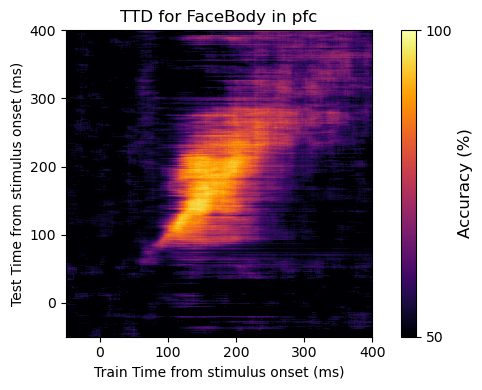

In [17]:
fig_sz = np.array((6,4)) * 1
plot_xylim = [-50, 400]
zero_lw = fig_sz[1]*.5
colormap = 'inferno'
# colormap = 'coolwarm'
# colormap = 'plasma'

plt.figure(figsize=fig_sz)
fig = plt.pcolor(time_stamps, time_stamps, ttd_task_ave*h_task, cmap=colormap, clim=clim, rasterized=True)
plt.gca().set_aspect('equal')

clb = plt.colorbar(mappable=fig, ticks=clim)
clb.set_label('Accuracy (%)', fontsize=fig_sz[0]*2)

# plt.contour(time_stamps, time_stamps, h_task, levels=[0.5], colors='grey', alpha=.5, lw=.1, linestyles='-')

# plt.axvline(0, color='w', ls='--', lw=zero_lw)
# plt.axhline(0, color='w', ls='--', lw=zero_lw)
# plt.fill_between(stim_pres_win, np.zeros_like(stim_pres_win)+plot_xylim[1], np.zeros_like(stim_pres_win)-100, color='w', alpha=.25, ls='None')
# plt.fill_betweenx(stim_pres_win, np.zeros_like(stim_pres_win)+plot_xylim[1], np.zeros_like(stim_pres_win)-100, color='w', alpha=.25, ls='None')

plt.xlim(plot_xylim)
plt.xticks([0,100,200,300,400])
plt.xlabel('Train Time from stimulus onset (ms)')

plt.ylim(plot_xylim)
plt.yticks([0,100,200,300,400])
plt.ylabel('Test Time from stimulus onset (ms)')

plt.title(f'TTD for {cond} in {region}')
plt.tight_layout()

# plt.savefig(f'{FigDir}ttd_py_{cond}_{region}.svg')